In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import h5py
#import scipy.io as so

mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = ','.join(r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 '''.split()))
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
%matplotlib inline

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
chlToN=1.6

In [3]:
saveloc='/data/eolson/MEOPAR/SS36runs/calcFiles/comparePhytoN/'
dirname1='hindcast2015'
dirname2='hindcast2016'
dirname3='hindcast2017'
dirnames=(dirname1,dirname2,dirname3)
plist=['Sentry Shoal','S3']
varNameDict={'Sentry Shoal':'SentryShoal', 'S3':'S3'}
with open('/ocean/eolson/MEOPAR/analysis-elise/notebooks/bioTuning/spathsMaster.txt') as f:
    spaths = dict(x.strip().split() for x in f)
ff=dict()
for idir in dirnames:
    ff[idir]=dict()
    for pl in plist:
        print(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
        ff[idir][pl]=nc.Dataset(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')

#ffN=dict()
#for idir in dirnames:
#    ffN[idir]=dict()
#    for pl in plist:
#        print(spaths[idir]+'ts_'+idir+'N_'+varNameDict[pl]+'.nc')
#        ffN[idir][pl]=nc.Dataset(spaths[idir]+'ts_'+idir+'N_'+varNameDict[pl]+'.nc')

/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_S3.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_S3.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2017_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2017_S3.nc


In [4]:
times=dict()
for idir in dirnames:
    f=ff[idir]['S3']
    torig=dt.datetime.strptime(f.variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S')
    print(torig)
    times[idir]=np.array([torig + dt.timedelta(seconds=ii) for ii in f.variables['time_centered'][:]])

1900-01-01 00:00:00
1900-01-01 00:00:00
1900-01-01 00:00:00


In [5]:
ff['hindcast2015']['S3'].variables.keys()

odict_keys(['ammonium', 'area', 'biogenic_silicon', 'bounds_lat', 'bounds_lon', 'ciliates', 'deptht', 'deptht_bounds', 'diatoms', 'dissolved_organic_nitrogen', 'e3t', 'flagellates', 'mesozooplankton', 'microzooplankton', 'nav_lat', 'nav_lon', 'nitrate', 'particulate_organic_nitrogen', 'silicon', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds'])

In [6]:
# load Sentry Shoal Nitrate
filepathN = '/ocean/eolson/MEOPAR/obs/Hakai/SentryShoal/Full_SUNA_Processed.mat'

arrays = {}
fSSN = h5py.File(filepathN)
for k, v in fSSN.items():
    arrays[k] = np.array(v)
ssdates = arrays['Full_SUNA_Processed'][0,:]
sstimes = arrays['Full_SUNA_Processed'][1,:]
sstemps = arrays['Full_SUNA_Processed'][2,:]
sssals = arrays['Full_SUNA_Processed'][3,:]
ssnitrate = arrays['Full_SUNA_Processed'][5,:]
ssdatenumber = arrays['Full_SUNA_Processed'][-1, :]
ssbase = dt.datetime(2000, 1, 1)
py_times = np.array([ssbase for i in range(63721)])
for n in range(63721):
    py_times[n] = ((dt.datetime.fromordinal(int(ssdatenumber[n])))
                       + dt.timedelta(days=ssdatenumber[n]%1)
                       - dt.timedelta(days = 366))
ssn = np.ma.masked_invalid(ssnitrate)


In [7]:
dfs=list()

In [8]:
flist1=['BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20140804T234330Z_20150604T070614Z-clean.csv',
       'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20150604T070624Z_20160307T160206Z-clean.csv',
       'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20150604T070624Z_20160307T160206Z-clean.csv',
       'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20160307T160215Z_20161019T064047Z-clean.csv',
       'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20161019T064056Z_20161115T220747Z-clean.csv']
for ii in range(0,len(flist1)):
    dfs.append(pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search3928586/'+flist1[ii],
        skiprows=78,header=None,usecols=[0,1,2,3,4,5,6,7,8,9,10],
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC')))

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
flist2=['BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170217T003041Z_20170315T031911Z-clean.csv',
       'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170315T031912Z_20170404T195130Z-clean.csv',
       'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170404T195131Z_20170426T173215Z-clean.csv',
       'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170426T173216Z_20170522T011843Z-clean.csv',
       'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170522T011844Z_20170611T234016Z-clean.csv',
       'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170611T234017Z_20170702T172228Z-clean.csv',
       'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170702T172229Z_20170722T182606Z-clean.csv',
       'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170722T182607Z_20170815T213737Z-clean.csv',
       'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170815T213738Z_20170825T225506Z-clean.csv']
for ii in range(0,len(flist2)):
    dfs.append(pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search4979680/'+flist2[ii],
        skiprows=67,header=None,usecols=[0,1,2,3,4,5,6,7,8,9,10],
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC')))

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (3,5,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,3,5,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1) have mixed types. Specify dtype option on impor

In [10]:
df=pd.concat(dfs,ignore_index=True)
dts=[dt.datetime(int(r[0:4]),int(r[5:7]),int(r[8:10]),int(r[11:13]),int(r[14:16]),int(r[17:19])) for r in df['TimeUTC']]
df=df.assign(dts=dts)
df['Lat']=pd.to_numeric(df['Lat'],errors='coerce')
df['Lon']=pd.to_numeric(df['Lon'],errors='coerce')

In [11]:
year={dirname1:'2015',dirname2:'2016',dirname3:'2017'}
tlim= dict()
for idir in dirnames:
    tlim[idir]=(np.min(times[idir]),np.max(times[idir]))

In [12]:
llon=places.PLACES['S3']['lon lat'][0]-.02
ulon=places.PLACES['S3']['lon lat'][0]+.02
llat=places.PLACES['S3']['lon lat'][1]-.02
ulat=places.PLACES['S3']['lon lat'][1]+.02

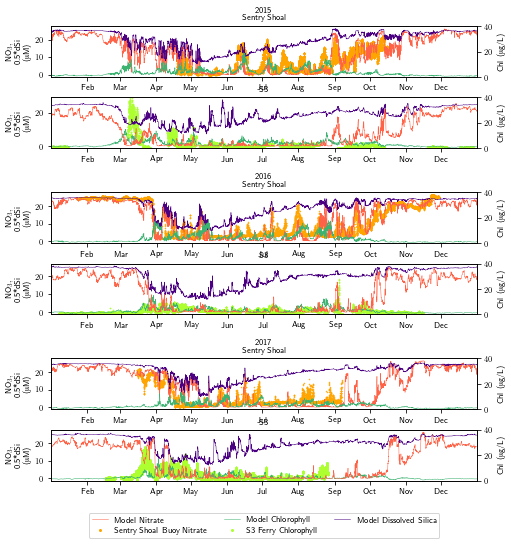

In [19]:
fig = plt.figure(figsize = (7.5,7.7))
gsv = gridspec.GridSpec(3,1,left=.11,right=.90,hspace=.36,bottom=.12,top=.94,height_ratios=[1,1,1])
gs15=gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=gsv[0],wspace=.3,hspace=.4,height_ratios=[1,1])
gs16=gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=gsv[1],wspace=.3,hspace=.4,height_ratios=[1,1])
gs17=gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=gsv[2],wspace=.3,hspace=.4,height_ratios=[1,1])
ax=dict()
for idir in dirnames:
    ax[idir]=dict()
    for rr in plist:
        ax[idir][rr]=dict()
            
ax[dirname1]['Sentry Shoal']['nit']=fig.add_subplot(gs15[0,0])
ax[dirname2]['Sentry Shoal']['nit']=fig.add_subplot(gs16[0,0])
ax[dirname3]['Sentry Shoal']['nit']=fig.add_subplot(gs17[0,0])
ax[dirname1]['S3']['chl']=fig.add_subplot(gs15[1,0])
ax[dirname2]['S3']['chl']=fig.add_subplot(gs16[1,0])
ax[dirname3]['S3']['chl']=fig.add_subplot(gs17[1,0])

for idir in dirnames:
    ax[idir]['Sentry Shoal']['chl']=ax[idir]['Sentry Shoal']['nit'].twinx()
    ax[idir]['S3']['nit']=ax[idir][rr]['chl'].twinx()
    ax[idir]['S3']['chl'].yaxis.set_label_position('right')
    ax[idir]['S3']['chl'].yaxis.set_ticks_position('right')
    ax[idir]['S3']['nit'].yaxis.set_label_position('left')
    ax[idir]['S3']['nit'].yaxis.set_ticks_position('left')

aalpha=1
lwid=.5
dateFmt = mdates.DateFormatter('%b')
iend={'S3':3,'Sentry Shoal':2}
for idir in dirnames:
    iiiSS=(py_times>=tlim[idir][0])&(py_times<=tlim[idir][1])
    pSSN,=ax[idir]['Sentry Shoal']['nit'].plot(py_times[iiiSS],ssn[iiiSS],'.',alpha=aalpha,color='orange',markersize=1)
    pSSN2,=ax[idir]['Sentry Shoal']['nit'].plot(dt.datetime(1900,1,1),1,'.',alpha=aalpha,color='orange',markersize=4)
    iiiFry=(df['dts']>=tlim[idir][0])&(df['dts']<=tlim[idir][1])&(df.Lon>llon)&(df.Lon<ulon)&(df.Lat>llat)&(df.Lat<ulat)
    pS3C,=ax[idir]['S3']['chl'].plot(df.loc[iiiFry,['dts']],df.loc[iiiFry,['Chlorophyll_ug']],'.',alpha=aalpha,color='greenyellow',markersize=1)
    pS3C2,=ax[idir]['S3']['chl'].plot(dt.datetime(1900,1,1),0,'.',alpha=aalpha,color='greenyellow',markersize=4)
    ax[idir]['Sentry Shoal']['nit'].set_title(year[idir]+'\nSentry Shoal')
    ax[idir]['S3']['nit'].set_title('S3')
    ax[idir]['Sentry Shoal']['nit'].set_xticklabels([])
    ax[idir]['Sentry Shoal']['chl'].set_xticklabels([])
    for rr in plist:
        fc=ff[idir][rr]
        #fn=ffN[idir][rr]
        pN,=ax[idir][rr]['nit'].plot(times[idir],
            np.sum(fc.variables['nitrate'][:,:iend[rr],0,0]*fc.variables['e3t'][:,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][:,:iend[rr],0,0],1),
                linestyle='-',alpha=aalpha,color='tomato',linewidth=lwid)
        pC,=ax[idir][rr]['chl'].plot(times[idir],
            chlToN*np.sum((fc.variables['diatoms'][:,:iend[rr],0,0]+fc.variables['flagellates'][:,:iend[rr],0,0]+\
                fc.variables['ciliates'][:,:iend[rr],0,0])*fc.variables['e3t'][:,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][:,:iend[rr],0,0],1),
                          linestyle='-',alpha=aalpha,color='mediumseagreen',linewidth=lwid)
        pS,=ax[idir][rr]['nit'].plot(times[idir],
            0.5*np.sum(fc.variables['silicon'][:,:iend[rr],0,0]*fc.variables['e3t'][:,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][:,:iend[rr],0,0],1),
            linestyle='-',alpha=aalpha,color='indigo',linewidth=lwid)
        ax[idir][rr]['chl'].set_xlim(tlim[idir])
        ax[idir][rr]['nit'].set_xlim(tlim[idir])
        ax[idir][rr]['chl'].xaxis.set_major_formatter(dateFmt)
        ax[idir][rr]['chl'].set_ylabel('Chl ($\muup$g/L)')
        ax[idir][rr]['nit'].set_ylabel('NO$_3,$\n0.5*dSi\n($\muup$M)')
        ax[idir][rr]['chl'].set_ylim(0,40)
ax[dirname3]['S3']['nit'].legend([pN,pSSN2,pC,pS3C2,pS],
                                 ('Model Nitrate','Sentry Shoal Buoy Nitrate','Model Chlorophyll','S3 Ferry Chlorophyll',
                                  'Model Dissolved Silica'),
                                ncol=3,loc='lower center',bbox_to_anchor=(.5,-1.2))

#fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsEval/tsSeasonalCycle.eps',dpi=200,transparent=True)

#fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsEval/tsSeasonalCycle.png',dpi=200,transparent=True)


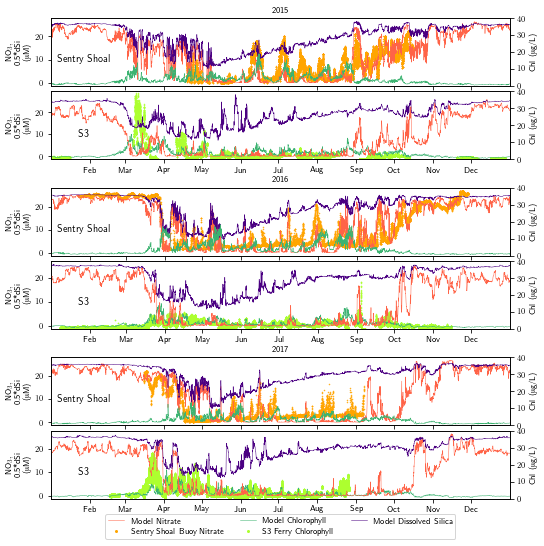

In [26]:
fig = plt.figure(figsize = (7.5,7.5))
gsv = gridspec.GridSpec(3,1,left=.09,right=.94,hspace=.2,bottom=.08,top=.97,height_ratios=[1,1,1])
gs15=gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=gsv[0],wspace=.3,hspace=.08,height_ratios=[1,1])
gs16=gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=gsv[1],wspace=.3,hspace=.08,height_ratios=[1,1])
gs17=gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=gsv[2],wspace=.3,hspace=.08,height_ratios=[1,1])
ax=dict()
for idir in dirnames:
    ax[idir]=dict()
    for rr in plist:
        ax[idir][rr]=dict()
            
ax[dirname1]['Sentry Shoal']['nit']=fig.add_subplot(gs15[0,0])
ax[dirname2]['Sentry Shoal']['nit']=fig.add_subplot(gs16[0,0])
ax[dirname3]['Sentry Shoal']['nit']=fig.add_subplot(gs17[0,0])
ax[dirname1]['S3']['chl']=fig.add_subplot(gs15[1,0])
ax[dirname2]['S3']['chl']=fig.add_subplot(gs16[1,0])
ax[dirname3]['S3']['chl']=fig.add_subplot(gs17[1,0])

for idir in dirnames:
    ax[idir]['Sentry Shoal']['chl']=ax[idir]['Sentry Shoal']['nit'].twinx()
    ax[idir]['S3']['nit']=ax[idir][rr]['chl'].twinx()
    ax[idir]['S3']['chl'].yaxis.set_label_position('right')
    ax[idir]['S3']['chl'].yaxis.set_ticks_position('right')
    ax[idir]['S3']['nit'].yaxis.set_label_position('left')
    ax[idir]['S3']['nit'].yaxis.set_ticks_position('left')

aalpha=1
lwid=.5
dateFmt = mdates.DateFormatter('%b')
iend={'S3':3,'Sentry Shoal':2}
for idir in dirnames:
    iiiSS=(py_times>=tlim[idir][0])&(py_times<=tlim[idir][1])
    pSSN,=ax[idir]['Sentry Shoal']['nit'].plot(py_times[iiiSS],ssn[iiiSS],'.',alpha=aalpha,color='orange',markersize=1)
    pSSN2,=ax[idir]['Sentry Shoal']['nit'].plot(dt.datetime(1900,1,1),1,'.',alpha=aalpha,color='orange',markersize=4)
    iiiFry=(df['dts']>=tlim[idir][0])&(df['dts']<=tlim[idir][1])&(df.Lon>llon)&(df.Lon<ulon)&(df.Lat>llat)&(df.Lat<ulat)
    pS3C,=ax[idir]['S3']['chl'].plot(df.loc[iiiFry,['dts']],df.loc[iiiFry,['Chlorophyll_ug']],'.',alpha=aalpha,color='greenyellow',markersize=1)
    pS3C2,=ax[idir]['S3']['chl'].plot(dt.datetime(1900,1,1),0,'.',alpha=aalpha,color='greenyellow',markersize=4)
    ax[idir]['Sentry Shoal']['nit'].set_title(label=year[idir])
    ax[idir]['Sentry Shoal']['nit'].text(dt.datetime(int(year[idir]),1,27),9,'Sentry Shoal',ha='center')
    ax[idir]['S3']['nit'].text(dt.datetime(int(year[idir]),1,27),9,'S3',ha='center')
    for rr in plist:
        fc=ff[idir][rr]
        #fn=ffN[idir][rr]
        pN,=ax[idir][rr]['nit'].plot(times[idir],
            np.sum(fc.variables['nitrate'][:,:iend[rr],0,0]*fc.variables['e3t'][:,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][:,:iend[rr],0,0],1),
                linestyle='-',alpha=aalpha,color='tomato',linewidth=lwid)
        pC,=ax[idir][rr]['chl'].plot(times[idir],
            chlToN*np.sum((fc.variables['diatoms'][:,:iend[rr],0,0]+fc.variables['flagellates'][:,:iend[rr],0,0]+\
                fc.variables['ciliates'][:,:iend[rr],0,0])*fc.variables['e3t'][:,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][:,:iend[rr],0,0],1),
                          linestyle='-',alpha=aalpha,color='mediumseagreen',linewidth=lwid)
        pS,=ax[idir][rr]['nit'].plot(times[idir],
            0.5*np.sum(fc.variables['silicon'][:,:iend[rr],0,0]*fc.variables['e3t'][:,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][:,:iend[rr],0,0],1),
            linestyle='-',alpha=aalpha,color='indigo',linewidth=lwid)
        ax[idir][rr]['chl'].set_xlim(tlim[idir])
        ax[idir][rr]['nit'].set_xlim(tlim[idir])
        ax[idir][rr]['chl'].xaxis.set_major_formatter(dateFmt)
        ax[idir][rr]['chl'].set_ylabel('Chl ($\muup$g/L)')
        ax[idir][rr]['nit'].set_ylabel('NO$_3,$\n0.5*dSi\n($\muup$M)')
        ax[idir][rr]['chl'].set_ylim(0,40)
    ax[idir]['Sentry Shoal']['nit'].set_xticklabels([])
    ax[idir]['Sentry Shoal']['chl'].set_xticklabels([])
ax[dirname3]['S3']['nit'].legend([pN,pSSN2,pC,pS3C2,pS],
                                 ('Model Nitrate','Sentry Shoal Buoy Nitrate','Model Chlorophyll','S3 Ferry Chlorophyll',
                                  'Model Dissolved Silica'),
                                ncol=3,loc='lower center',bbox_to_anchor=(.5,-.65))

fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsEval/tsSeasonalCycle.eps',dpi=200,transparent=True)

fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsEval/tsSeasonalCycle.png',dpi=200,transparent=True)
